# IEEE Fraud Detection

La détection des fraudes en ligne est l'une des problématiques les plus courantes et sensibles dans de nombreux secteurs, en particulier les banques. Au cours des dernières années, les tentatives de fraude ont connu une forte hausse, ce qui rend la lutte contre ce phénomène très importante. 

Cette compétition est un problème de classification binaire - c'est-à-dire que notre variable cible est un attribut binaire (l'utilisateur fait-il le clic frauduleux ou non?)

Et notre objectif est de classer les utilisateurs en "frauduleux" ou "non frauduleux" le mieux possible.

On cherche à prédire la probabilité qu'une transaction en ligne soit frauduleuse.

# Packages nécessaires

In [1]:
import numpy as np     
import pandas as pd   
import matplotlib.pyplot as plt   
import seaborn as sns        

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import time
import random
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

sns.set() 

# Import des données

Commençons par vérifier les données submission.

In [3]:
data_sub = pd.read_csv('C:/Users/boubekeur/Documents/datacamp/sample_submission.csv')
data_sub.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [4]:
del data_sub

On charge maintenant, les données trains et tests. Les données sont divisées en deux fichiers d'identité et de transaction

In [69]:
train_id = pd.read_csv('/home/amina/Documents/train_identity.csv',nrows=3000)
train_trans = pd.read_csv('/home/amina/Documents/train_transaction.csv',nrows=3000)
test_id = pd.read_csv('/home/amina/Documents/test_identity.csv',nrows=3000)
test_trans = pd.read_csv('/home/amina/Documents/test_transaction.csv',nrows=3000)

In [70]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


On rassemble les données train et test via la variable TransactionID.

In [71]:
TransactionID = test_id["TransactionID"]

In [72]:
train = pd.merge(train_trans, train_id, on='TransactionID', how='left')
test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

In [73]:
del train_id, train_trans, test_id, test_trans

 - Réduction de mémoire

In [74]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [75]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to  3.06 Mb (69.3% reduction)
Mem. usage decreased to  3.06 Mb (69.2% reduction)


# Visualisation des données

Tout d'abord, on visualise les données à l'aide de graphiques et de tests statistiques.

**Données "object"**

In [76]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
print(cat_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


 Variables discrètes :

 - ProductCD
 - emaildomain
 - card1 - card6
 - addr1, addr2
 - P_emaildomain
 - R_emaildomain
 - M1 - M9
 - DeviceType
 - DeviceInfo
 - id_12 - id_38

Le reste des variables sont numériques.

Nous avons quelques informations sur certaines variables :

 - TransactionDT: timedelta à partir d'une datetime de référence donnée (pas un horodatage réel)
 - TransactionAMT: c'est le montant de la transaction en USD
 - ProductCD: code produit pour chaque transaction
 - card1 - card6: Informations sur la carte de paiement
 - addr: adresse de l'acheteur et du destinataire
 - addr1: région de facturation
 - addr2: pays de facturation
 - dist: distance entre (sans limitation) l'adresse de facturation, l'adresse postale, le code postal, l'adresse IP, la zone téléphonique, etc. 
 - Domaine de messagerie P_ et (R_): domaine de messagerie de l'acheteur et du destinataire 
 - C1-C14: comptage, comme le nombre d'adresses associées à la carte de paiement, etc. La signification réelle est masquée. 
 - D1-D15: Timedelta, comme les jours entre la transaction précédente, etc. 
 - M1-M9: Correspondance, comme les noms sur la carte et l'adresse, etc.
 - Vxxx: Vesta a conçu de riches fonctionnalités, notamment le classement, le comptage et d'autres relations d'entité.
 - id01-id11: Fonctionnalités numériques pour l'identité
 - IsFraud = 1 signifie transaction fradulente, sinon transaction non-fradulente.

## Target : isFraud

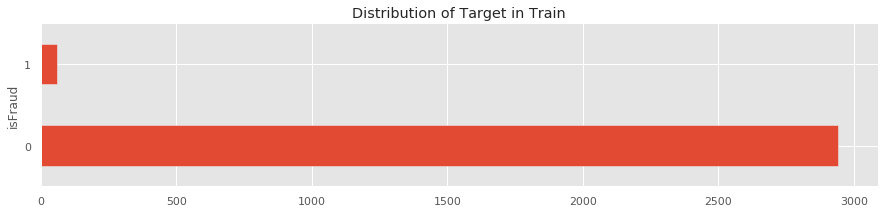

In [77]:
train.groupby('isFraud') \
    .count()['TransactionID'] \
    .plot(kind='barh',
          title='Distribution of Target in Train',
          figsize=(15, 3))
plt.show()

On peut voir clairement que la plupart des transactions sont non frauduleuses. 

Si on utilise cette base de données comme base pour nos modèles prédictifs et nos analyses, nous pourrions obtenir beaucoup d'erreurs et nos algorithmes seront probablement trop adaptés car ils "supposeront" que la plupart des transactions ne sont pas frauduleuses.

## Transaction Amt

Cette variable décrit le montant de la transaction.

On trace la distribution du logarithme de cette variable pour obtenir une représentation de la variable plus lisible.

In [78]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

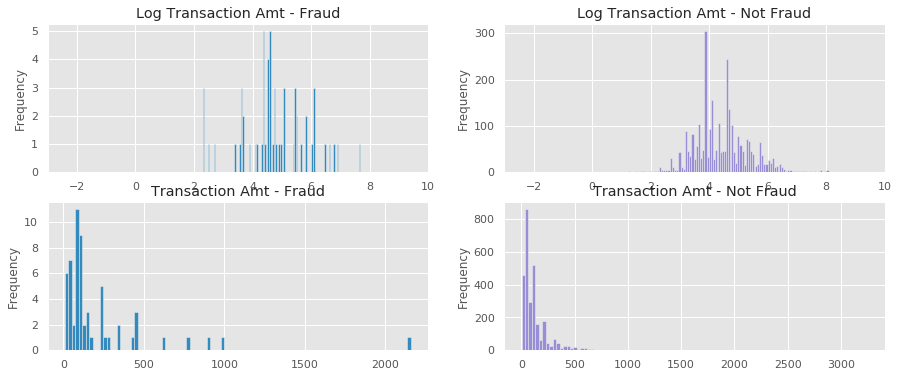

In [79]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color=color_pal[1],
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color=color_pal[2],
          xlim=(-3, 10),
         ax=ax2)
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color=color_pal[1],
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color=color_pal[2],
         ax=ax4)
plt.show()


In [80]:
print('Mean transaction amt for fraud is {:.4f}'.format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 217.3750
Mean transaction amt for non-fraud is inf


In [81]:
from scipy import stats
print(stats.ttest_ind(train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] ,train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] ,equal_var=False))

Ttest_indResult(statistic=0.0, pvalue=1.0)


On teste si la moyenne du montant des transactions dans le groupe des transactions frauduleuses et égale à la moyenne du montant des transactions dans le groupe des transactions non-frauduleuses.

En faisant un test de student on remarque qu'il y a une différence significative entre les deux moyennes.

## ProductCD

Le produit pour chaque transaction.

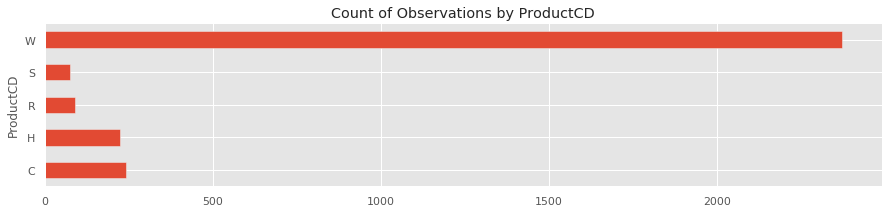

In [82]:
train.groupby('ProductCD') \
    ['TransactionID'].count() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Count of Observations by ProductCD')
plt.show()

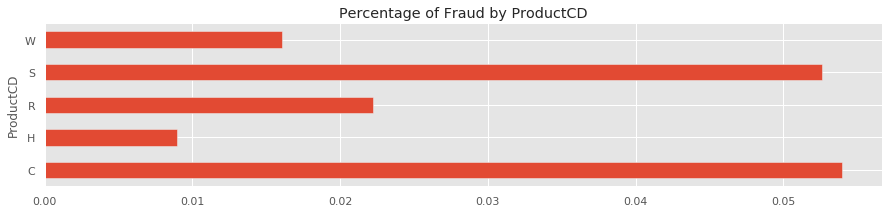

In [83]:
train.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()

On observe que :
 - W a le plus grand nombre d'observations, S a le moins.
 - C a le plus grand pourcentage de fraude >11%
 - W a le moins avec <2%

## card1 - card6

Informations sur les cartes de paiement.

In [84]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [85]:
color_idx = 0
for c in card_cols:
    if train[c].dtype in ['float64','int64']:
        train[c].plot(kind='hist',
                                      title=c,
                                      bins=50,
                                      figsize=(15, 2),
                                      color=color_pal[color_idx])
    color_idx += 1
    plt.show()

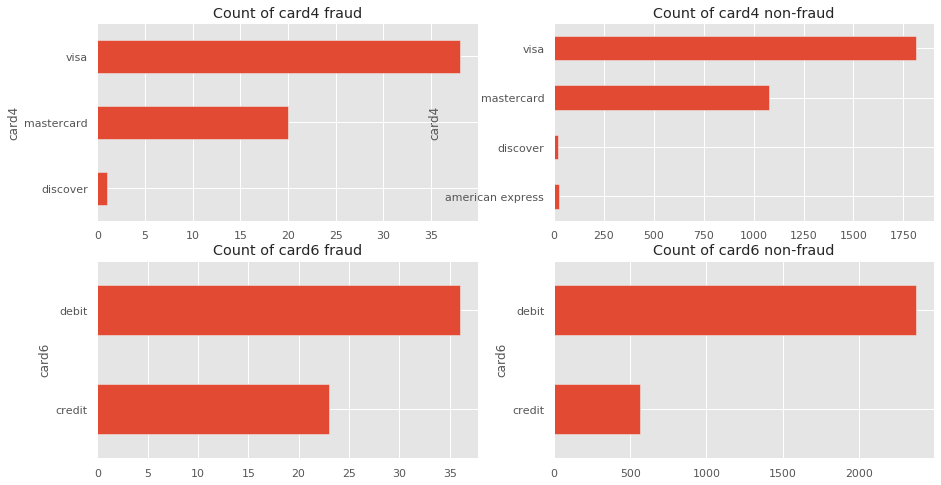

In [86]:
train_fr = train.loc[train['isFraud'] == 1]
train_nofr = train.loc[train['isFraud'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))
train_fr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax1, title='Count of card4 fraud')
train_nofr.groupby('card4')['card4'].count().plot(kind='barh', ax=ax2, title='Count of card4 non-fraud')
train_fr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax3, title='Count of card6 fraud')
train_nofr.groupby('card6')['card6'].count().plot(kind='barh', ax=ax4, title='Count of card6 non-fraud')
plt.show()

## DeviceType

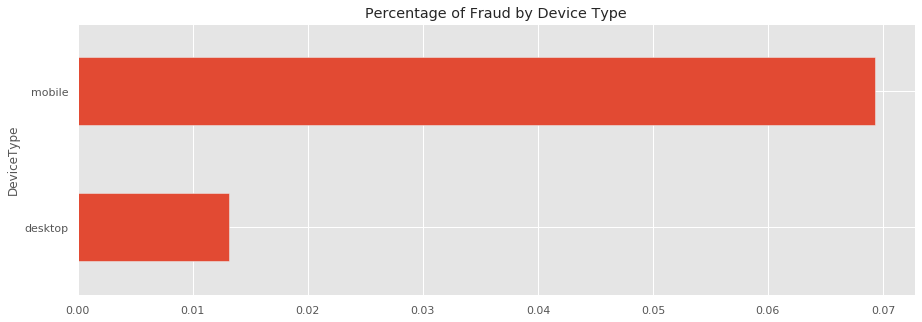

In [87]:
train.groupby('DeviceType') \
    .mean()['isFraud'] \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Percentage of Fraud by Device Type')
plt.show()

## DeviceInfo

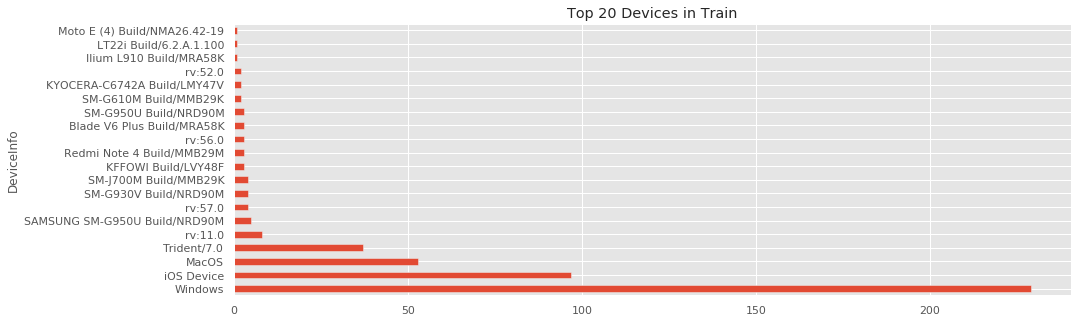

In [88]:
train.groupby('DeviceInfo') \
    .count()['TransactionID'] \
    .sort_values(ascending=False) \
    .head(20) \
    .plot(kind='barh', figsize=(15, 5), title='Top 20 Devices in Train')
plt.show()

## TransactionDT

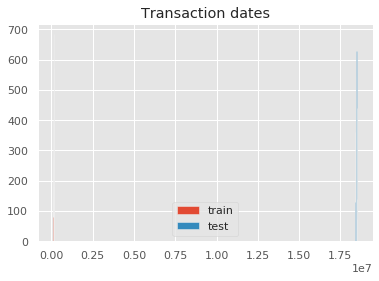

In [89]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Transaction dates');

Ci-dessus, on voit que les dates des données Train et Test ont une intersection vide.

In [90]:
y_train = train.isFraud
train = train.drop(['isFraud', 'TransactionID'],axis= 1)
transactionIDTest = test['TransactionID']
test = test.drop('TransactionID', axis= 1)
train.shape, test.shape

((3000, 432), (3000, 432))

# Valeurs manquantes

**Nettoyage des NaN**

**Train**

In [91]:
missing_values_count = train.isnull().sum()
print (missing_values_count[0:10])
total_cells = np.product(train.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

TransactionDT       0
TransactionAmt      0
ProductCD           0
card1               0
card2              51
card3               0
card4               0
card5               5
card6               0
addr1             243
dtype: int64
% of missing data =  48.9162037037037


On peut voir que 45% des données du train sont des valeurs manquantes, nettoyons tout ça !

In [92]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.911667
0.0    0.082667
1.0    0.001667
2.0    0.001667
3.0    0.001667
Name: id_03, dtype: float64

 - On supprime les variables qui ont plus de 80% de NA

In [93]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.8]
    return many_null_cols

In [94]:
null_cols = get_too_many_null_attr(train)
train.drop(null_cols,1,inplace=True)

In [95]:
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

On peut voir que 88% des données sont des NaN, et 10% sont des valeurs nulles. Soit 98% des données sont des valeurs manquantes, donc inutiles !

On sépare les variables qualitatives et quantitatives : 

In [96]:
mask1 = train.dtypes==object
categoricalColumns = train.columns[mask1]
categoricalFeatures = train[categoricalColumns]
categoricalFeatures.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6
0,W,discover,credit,NaN,T,T,T,M2,F,T
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,M0,T,T
2,W,visa,debit,outlook.com,T,T,T,M0,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,M0,T,F
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
mask2 = train.dtypes!=object
numericalColumns = train.columns[mask2]
numericalFeatures = train[numericalColumns]
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Corrélations entre les variables numériques

On cherche à observer visuellement s'il existe des corrélations entre certaines variables.

In [98]:
correlations = numericalFeatures[['id_01','id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19', 'id_20']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(categoricalFeatures)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations


KeyError: "None of [Index(['id_01', 'id_02', 'id_05', 'id_06', 'id_11', 'id_13', 'id_17', 'id_19',\n       'id_20'],\n      dtype='object')] are in the [columns]"

In [ ]:
correlations = numericalFeatures[['TransactionAmt','TransactionDT','card2','card3','card5']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(categoricalFeatures)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

On remarque qu'il n'y a pas de corrélations flagrante entre ces variables.

 - Normalisation des variables numériques : 
 
 $\frac{X - \mu}{\sigma}$, avec $\mu$ : la moyenne de X et $\sigma$ : l'écart-type de X.

In [99]:
numericalFeatures = (numericalFeatures-numericalFeatures.mean())/numericalFeatures.std()

In [100]:
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,-1.754436,-0.305908,0.865250,NaN,-0.268066,-1.610352,0.211426,0.0,-0.274658,-0.196289,...,-0.224365,-0.162842,-0.221436,-0.189453,-0.132324,-0.024063,-0.129761,-0.114136,-0.168213,-0.125732
1,-1.754391,-0.455811,-1.507197,0.359131,-0.268066,-2.685547,0.308594,0.0,NaN,-0.196289,...,-0.224365,-0.162842,-0.221436,-0.189453,-0.132324,-0.096008,-0.129761,-0.114136,-0.168213,-0.125732
2,-1.751313,-0.341797,-1.101984,0.898926,-0.268066,-0.964844,0.357178,0.0,0.484131,-0.196289,...,-0.224365,-0.162842,-0.221436,-0.189453,-0.132324,-0.096008,-0.129761,-0.114136,-0.168213,-0.125732
3,-1.749955,-0.375977,1.758501,1.381836,-0.268066,-2.283203,1.776367,0.0,NaN,-0.174316,...,0.889160,-0.162842,-0.221436,-0.189453,0.013588,0.767578,1.307617,-0.114136,-0.168213,-0.125732
4,-1.749638,-0.375977,-1.137239,1.049805,-0.268066,-2.685547,1.232422,0.0,NaN,-0.196289,...,-0.224365,-0.162842,-0.221436,-0.189453,-0.132324,-0.096008,-0.129761,-0.114136,-0.168213,-0.125732


Si une variable a la même valeur, la nouvelle valeur après normalisation sera égale à NaN. 

Ainsi, nous supprimerons les variables qui ont des NaN après la normalisation.

In [101]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNullScaled = numericalFeatures.columns[nonNull]
columnNonNullScaled

Index(['card2', 'card5', 'addr1', 'addr2', 'dist1', 'D2', 'D3', 'D4', 'D5',
       'D10',
       ...
       'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V107', 'V117',
       'V305'],
      dtype='object', length=109)

In [102]:
numericalFeatures = numericalFeatures.drop(columnNonNullScaled, axis = 1)

In [103]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNull = numericalFeatures.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [104]:
numericalFeatures.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card3', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=102)

## Pré-traitement de l'échantillon Test

Dans un premier temps, on renomme le nom des colonnes de l'ensemble de données de test: on remplace - par _

In [105]:
droppedColumnsTest = []
for i in test.columns:
  a = i.replace('-','_')
  droppedColumnsTest.append(a)
test.columns = droppedColumnsTest

 - Extraction des variables numériques et qualitatives

In [106]:
X_testCategorical = test[categoricalFeatures.columns]

In [107]:
X_testNumerical  = test[numericalFeatures.columns]

 - Suppression des variables contenant plus de 80% de valeurs manquantes

In [108]:
null_cols = get_too_many_null_attr(X_testNumerical)
X_testNumerical.drop(null_cols,1,inplace=True)

On vérifie si les variables catégorielles du train et du test ont le même nombre de valeurs uniques avant l'encodage

In [109]:
categoricalFeatures.describe()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6
count,3000,3000,3000,2326,1206,1206,1206,1448,1206,2297
unique,5,4,2,40,1,2,2,3,2,2
top,W,visa,debit,gmail.com,T,T,T,M0,F,F
freq,2370,1852,2411,1041,1206,1084,909,1023,633,1270


In [110]:
X_testCategorical.describe()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6
count,3000,3000,3000,2515,2359,2359,2359,1481,1245,2488
unique,5,4,2,44,1,2,2,3,2,2
top,W,visa,debit,gmail.com,T,T,T,M0,F,F
freq,2582,2013,2458,1244,2359,2190,1948,949,682,1337


On remarque que certaines variables catégorielles ont une valeur unique différente dans le train et dans le test. 

Cela conduira à différentes formes du train et du test. On a alors décidé de supprimer ces variables.

Suppression des variables catégorielles ayant des valeurs uniques différentes dans le train et le test, avant l'encodage

In [111]:
A = []
for i in X_testCategorical.columns:
  if len(X_testCategorical[i].value_counts()) != len(categoricalFeatures[i].value_counts()):
    A.append(i)
A

['P_emaildomain']

In [112]:
categoricalFeatures = categoricalFeatures.drop(A, axis = 1)
X_testCategorical = X_testCategorical.drop(A, axis = 1)

## Les chaînes de caractères : one hot encoder

Pour pourvoir utiliser les variables contenant des chaînes de caractères, on utilise la méthode de one hot encoder qui consiste à créer des nouvelles colonnes correspondant à chaque valeur que peut prendre les variables qualitatives, puis inscrire la valeur 1 si un individu a pour valeur de variable le nom de la colonne, 0 sinon.

En effet, nous n'utiliserons pas la méthode de label encoder consistant à remplacer les valeurs des variables qualitatives par des chiffres car cela impliquerait qu'il y aurait des relations de supériorité entre les valeurs qualitatives.

On utilise la méthode _get_dummies_ pour coder les variables catégorielles du train et du test

In [113]:
def encodingTrain():
  x = pd.get_dummies(categoricalFeatures, columns= categoricalFeatures.columns)
  return x.join(numericalFeatures) 

In [114]:
X_trainEncoded = encodingTrain()

In [115]:
def encodingTest():
  x = pd.get_dummies(X_testCategorical, columns= X_testCategorical.columns) 
  return x.join(X_testNumerical)

In [116]:
X_testEncoded = encodingTest()

On vérifie la forme des ensembles du train et du test après l'encodage

In [117]:
X_trainEncoded.shape, X_testEncoded.shape, y_train.shape

((3000, 125), (3000, 125), (3000,))

On vérifie si y a pas de NAN dans le train et le test après l'encodage

In [118]:
nonNull = X_trainEncoded.isnull().sum() != 0
columnNonNull = X_trainEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [119]:
nonNull = X_testEncoded.isnull().sum() != 0
columnNonNull = X_testEncoded.columns[nonNull]
columnNonNull

Index(['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301',
       'V313', 'V314', 'V315'],
      dtype='object')

On vérifie si le nom des colonnes dans le train et le test est le même

In [120]:
A = X_trainEncoded.columns == X_testEncoded.columns
A.sum() == len(X_trainEncoded.columns)

True

Le nom des colonnes dans le train et dans le test est le même. 

Maintenant, on va construire le modèle qui peut éviter le surapprentissage car on a beaucoup de variables.

# Prédiction de la probabilité du nombre de fraudes

In [121]:
Y = y_train 
X = X_trainEncoded

#### Split nos données en train(67%) et test(33%)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Naive Bayes

Dans un premier temps, nous avons appliqué le classifier Naive Bayes.
Son utilisation ne nécessite pas l'ajustement des hyperparamètres.

La classification naïve bayésienne est un type de classification bayésienne probabiliste simple basée sur le théorème de Bayes avec une forte indépendance des hypothèses.

Avantages et inconvénients de Naive Bayes:

Avantages

 - C’est relativement simple à comprendre et à construire
 - Il est facile à former, même avec un petit jeu de données
 - C’est rapide!
 - Il n’est pas sensible aux caractéristiques non pertinentes

Désavantages

 - Il implique que chaque fonctionnalité soit indépendante, ce qui n’est pas toujours le cas.

Les classificateurs de Naïve Bayes sont une famille d’algorithmes reposant sur le principe commun selon lequel la valeur d’une fonctionnalité spécifique est indépendante de la valeur de toute autre fonctionnalité. Ils nous permettent de prédire la probabilité qu’un événement se produise en fonction de conditions que nous connaissons pour les événements en question. 

In [123]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(roc_auc_score(y_test,gnb.predict_proba(X_test)[:,1] ))

0.5217455403213918


## Knn

In [138]:
knn = KNeighborsClassifier()
# on crée un dictionnaire pour les nombres de voisins n_neighbors que l'on veut tester 
param_grid = {'n_neighbors': np.arange(1, 5)}

#on utilise gridsearch pour tester toutes les valeurs de n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)

#on fit le modèle
knn_best = knn_gscv.fit(X_train, y_train)

In [139]:
# la meilleure valeur de n_neighbors vaut 2
knn_gscv.best_params_

{'n_neighbors': 2}

In [140]:
#la moyenne des score pour cette valeur de n_neighbors 
knn_gscv.best_score_


0.9805970149253731

Pour cette valeur du nombre de voisins, l'accuracy sur le train est de 0.98

In [141]:
pred= knn_best.predict(X_test)
roc_auc_score(y_test, pred)

0.5

Pour ce modèle on trouve alors une valeur d'AUC de 

## Régression logistique

In [ ]:
def temps(second):
    m, s = divmod(second, 60)
    h, m = divmod(m, 60)
    print("temps :",'{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s))

### Regression logistique avec toutes nos variables 

In [ ]:
tstart = time.time()
log = LogisticRegression(random_state=0).fit(X_train, y_train)
pred_train = log.predict_proba(X_train)
print("score auc train :",roc_auc_score(y_train, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

In [ ]:
tstart = time.time()
pred = log.predict_proba(X_test)
print("score auc test :",roc_auc_score(y_test, pred[:, 1]))
tend = time.time()
temps(tend-tstart)

## Regression logistique avec cross validation

### cross validation sur toutes nos données

In [ ]:
tstart = time.time()
clf = LogisticRegression(random_state=0)
scores = cross_val_score(clf, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores)
tend = time.time()
temps(tend-tstart)

On peut constater que l'on obtient un auc de 0.827 qui est le plus élevé obtenu jusqu'à présent

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sample = cross_val_score(clf, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sample)
tend = time.time()
temps(tend-tstart)

Les auc obtenu avec une penalty l1 sont bien meilleurs que ceux obtenus prédédement. Le temps de d'exécution est en revanche bien plus grand avec cette méthodes.

## Cross validation pour le paramètre Inverse of regularization strength

In [ ]:
pred = []
tstart = time.time()
t = np.arange(0.1,1.1,0.1)
for i in t:
    if(i%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_train, y_train)
    pred_train = log.predict_proba(X_test)
    pred.append(roc_auc_score(y_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

In [ ]:
print("Pour C = ",t[np.argmax(pred)], " ,auc = ",np.max(pred))

In [ ]:
pred = []
tstart = time.time()
t = np.arange(0.01,0.11,0.01)
for i in t:
    if((i*10)%2==0): print(i)
    log = LogisticRegression(solver ='liblinear', penalty = 'l1', C=i, random_state=0).fit(X_train, y_train)
    pred_train = log.predict_proba(X_test)
    pred.append(roc_auc_score(y_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

plt.plot(t,pred)

In [ ]:
print("Pour C = ",t[np.argmax(pred)], " ,auc = ",np.max(pred))

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.03, penalty = 'l1', random_state=0)
scores_sub_sc = cross_val_score(clf, X, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_sc)
tend = time.time()
temps(tend-tstart)

In [ ]:
pred = []
tstart = time.time()
t = np.arange(0,1.1,0.1)
for i in t:
    if((i*10)%2==0): print(i)
    log = LogisticRegression(solver ='saga', penalty = 'elasticnet', random_state=0, l1_ratio=i).fit(X_train, y_train)
    pred_train = log.predict_proba(X_test)
    pred.append(roc_auc_score(y_test, pred_train[:, 1]))
tend = time.time()
temps(tend-tstart)

In [ ]:
plt.plot(t,pred)

On essaie de melanger les données (toutes les données non fraude sont en haut et fraude en bas du DataFrame)


In [ ]:
X_shuffle = X.join(Y.reset_index(drop=True))
X_shuffle = X_shuffle.sample(frac=1).reset_index(drop=True)

In [ ]:
Y_sh = X_shuffle["isFraud"]
X_sh = X_shuffle.loc[:, X_shuffle.columns != "isFraud"]

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sh = cross_val_score(clf, X_sh, Y_sh, cv=5,scoring='roc_auc')
print("score auc :",scores_sh)
tend = time.time()
temps(tend-tstart)

# Selection de variables avec Lasso

### Variables sélectionner par Lasso pour  $\lambda$=1

In [ ]:
clf = linear_model.Lasso(alpha=1)
clf.fit(X,Y)


In [ ]:
coef = clf.coef_
col_ohe = X.columns
var_ohe = col_ohe[coef!=0]
X_lasso = X[var_ohe]

In [ ]:
print(len(var_ohe))

Nous pouvons constater que la plupart des coefficients ont été mis à zéros

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

###  Variables sélectionner par Lasso pour $\lambda$ =0.1 

In [ ]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X,Y)

In [ ]:
coef = clf.coef_
col_ohe = X.columns

In [ ]:
var_ohe = col_ohe[coef!=0]
print(len(var_ohe))

Nous pouvons voir qu'en ce lambda le nombre de coefficient différents de zéros à augmenter

In [ ]:
X_lasso = X[var_ohe]

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.04, penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', C=0.04, penalty = 'l1', random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

### Variables sélectionner par Lasso pour  𝜆 =0.01

In [ ]:
clf = linear_model.Lasso(alpha=0.01)
clf.fit(X,Y)

In [ ]:
coef = clf.coef_
col_ohe = X.columns
var_ohe = col_ohe[coef!=0]
X_lasso = X[var_ohe]

In [ ]:
print(len(var_ohe))

Nous pouvons constater que le nombre de coefficients différents de zéros a encore augmenté

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=5,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

In [ ]:
tstart = time.time()
clf = LogisticRegression(solver ='liblinear', penalty = 'l1', C=0.04, random_state=0)
scores_sub_lasso = cross_val_score(clf, X_lasso, Y, cv=10,scoring='roc_auc')
print("score auc :",scores_sub_lasso)
tend = time.time()
temps(tend-tstart)

## Random Forest

Random Forest est un modèle composé de nombreux arbres de décision. Plutôt que de simplement faire la moyenne de la prédiction des arbres (que nous pourrions appeler une «forêt»), ce modèle utilise deux concepts clés qui lui donnent le nom aléatoire:

- Échantillonnage aléatoire des points de données d'entraînement lors de la construction d'arbres

- Sous-ensembles aléatoires de variables pris en compte lors de la division des nœuds

**Avantages:**

- L'algorithme _Random Forest_ est considéré comme une méthode très précise et robuste en raison du nombre d'arbres de décision participant au processus.

- Rapide dans les calculs

- Classe les variables explicatives en fonction de leur lien avec les variables à expliquer 

- Il ne souffre pas du problème de sur-ajustement. La raison principale est qu'il prend la moyenne de toutes les prédictions, ce qui annule les biais.

- On peut obtenir l'importance relative des variables, ce qui aide à sélectionner les variables les plus contributives pour le classificateur.

**Paramètres:**

- _n_estimators:_ Nombre d'arbres dans la forêt. La valeur par défaut est 10.

- _min_samples_split:_ nombre minimum de  nœud requis pour la division. La valeur par défaut est 2.

- _max_features:_  nombre de variables à considérer lors de la recherche de la meilleure répartition. si 'sqrt' alors max_features = sqrt (n_features)

- _n_jobs_= -1 signifie utiliser tous les processeurs


In [ ]:
#Création du modèle
tstart = time.time()
rf = RandomForestClassifier(n_jobs=-1, n_estimators = 40,max_features = 'sqrt')
rf_fit=rf.fit(X_train, y_train)
tend = time.time()
temps(tend-tstart)

Après quelques secondes d'entrainement, le modèle est prêt à faire des prédictions sur les données de test comme suit:

In [ ]:
tstart = time.time()
rf_predict = rf.predict(X_test)
tend = time.time()
temps(tend-tstart)

On peut voir combien de noeuds il y a en moyenne pour chaque arbre et la profondeur maximale de chaque arbre. 

In [ ]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')



On peut voir que chaque arbre de décision dans la forêt a de nombreux noeuds et est extrêmement profond. Cependant, même si chaque arbre de décision individuel peut s'adapter à un sous-ensemble particulier des données d'entrainement, l'idée est que la forêt aléatoire globale devrait avoir une variance réduite.

**Evaluation des performances:**


In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test,rf_predict ))

- Matrice de confusion

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [ ]:
cm = confusion_matrix(y_test, rf_predict)
plot_confusion_matrix(cm, classes = ['0', '1'],
                      title = 'transaction Confusion Matrix')


Cela montre les classifications prévues par le modèle sur les données de test ainsi que les labels réels. Nous pouvons voir que notre modèle a de nombreux faux positifs (une transaction non frauduleuse prédite mais en fait une transaction frauduleuse)

**Optimisation Random Forest:**

- **Option 1:**

En s'aidant de l'article de William Koehrsen, «Hyperparameter Tuning the Random Forest in Python» 

On a utilisé RandomizedSearchCV de sklearn pour optimiser nos hyperparamateurs. Koehrsen utilise une grille complète d'hyperparamètres dans son article, mais on a trouvé que cela pouvait prendre beaucoup de temps pour s'exécuter dans la pratique. on a décidé de me concentrer sur 3 hyperparamètres: n_estimators, max_features et max_depth.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
max_features = [‘auto’, ‘sqrt’]

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)# create random grid
random_grid = {
 ‘n_estimators’: n_estimators,
 ‘max_features’: max_features,
 ‘max_depth’: max_depth
 }# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)
print(rfc_random.best_params_)

- **Option 2:**

Afin de maximiser les performances de notre modèle, on peut effectuer une recherche aléatoire de meilleurs hyperparamètres. Cela sélectionnera de manière aléatoire des combinaisons d'hyperparamètres à partir d'une grille, les évaluera à l'aide d'une validation croisée sur les données d'entraînement et renverra les valeurs les plus performantes.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 700, num = 10)]
max_features = [‘auto’, ‘sqrt’]

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)# create random grid
random_grid = {
 ‘n_estimators’: n_estimators,
 ‘max_features’: max_features,
 ‘max_depth’: max_depth
 }# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)
print(rfc_random.best_params_)

On a fait tourner cette partie du code sur un ordinateur plus puissant, l'agorithme a fait 300 calculs et 3 fit et pour chaque fit 100 estimation. temps de calcul 9h 

Résultat: n_estimators = 485, max_features='sqrt',max_depth=164

**Variables importantes:**

On jete un oeil aux variables considérées comme les plus importantes par notre modèle. Les valeurs sont calculées se basant sur le coefficient de Gini de l'impureté d'un noeud.

In [ ]:
fi = []
fiName = []
for feat, importance in zip(X.columns, rf.feature_importances_):
  if importance!= 0:
      fi.append(importance)
      fiName.append(feat)
      print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

In [ ]:
len(fi)

On a au total 126 variables importantes.

On trace 10 variables importantes retourner par notre modèle

In [ ]:
sns.barplot(x=fi[0:10], y=fiName[0:10])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

**Utilisation du meilleur modèle (variables importantes)**

Maintenant, on va prendre le meilleur modèle (qui a été formé) et l'évaluer. Espérons que celui là retourne un meilleur résultat

In [ ]:
X_trainEncodedBest = X_train[fiName]
X_testEncodedBest = X_test[fiName]

- **Option 1:**

In [ ]:
rf_best=RandomForestClassifier( n_estimators = 485, max_features='sqrt',max_depth=164)

In [ ]:
tstart=time.time()
rf_best.fit(X_trainEncodedBest_rf,y_train)
tend = time.time()
temps(tend-tstart)

In [ ]:
rf_predict_best = rf_best.predict(X_testEncodedBest_rf)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test,rf_predict_best ))

- **Option 2:**

In [ ]:
rf_best2=RandomForestClassifier( n_estimators = 188,min_samples_split=2,max_leaf_nodes= 33,max_features=0.79
                               ,max_depth=12,bootstrap= True)

In [ ]:
tstart=time.time()
rf_best2.fit(X_trainEncodedBest_rf,y_train)
tend = time.time()
temps(tend-tstart)

In [ ]:
rf_predict_best2 = rf_best2.predict(X_testEncodedBest_rf)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test,rf_predict_best2 ))

On remarque une très légère amélioration, l'accuracy est passée de 98,23% à 98,26% celà est peut être dû aux hyperparamètres choisis par nous même. On a essayé de faire une recherche aléatoire des meilleurs hyperparamètres . Cette méthode n'a pas retourné un meilleur résultat. 

## Adaptive Boosting

Adaboost combine plusieurs apprenants faibles en un seul apprenant fort. 

Les apprenants faibles dans AdaBoost sont des arbres de décision avec une seule division, appelés souches de décision. 

Lorsque AdaBoost crée son premier noeud de décision, toutes les observations sont pondérées de manière égale. Pour corriger l'erreur précédente, les observations incorrectement classées ont désormais plus de poids que les observations correctement classées. Les algorithmes AdaBoost peuvent être utilisés pour les problèmes de classification.

Optimisation des hyperparamètres

In [ ]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 1]}
gridCv = GridSearchCV(AdaBoostClassifier(), param_grid= parameters, cv=3, scoring='roc_auc')

In [ ]:
begin = time.time()
gridCv.fit(X,Y)
end = time.time()

In [ ]:
print("Time execution for optimizing hyperparapeter is {a} minutes.".format(a =(end-begin)/60))

Meilleur paramètre, meileur estimateur et AUC

In [ ]:
gridCv.best_params_

In [ ]:
gridCv.best_estimator_

In [ ]:
gridCv.best_score_

Model AdaBoost avec toutes les variables

In [ ]:
Model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=None)

In [ ]:
Model.fit(X,Y)

Probabilités prédites par le modèle

In [ ]:
predictedProba1 = pd.DataFrame(Model.predict_proba(X_test), columns=['0','1'])


In [ ]:
fraudTransaction = predictedProba1['1']
nonFraudTransaction = predictedProba1['0']

Adaboost Model avec seulement les variables importantes :

On utilise la méthode feature_importances_ pour trouver les variables importantes.

In [ ]:
importantFeature = []
importantFeatureName = []
for feat, importance in zip(X.columns, gridCv.best_estimator_.feature_importances_):
  if importance!= 0:
      importantFeature.append(importance)
      importantFeatureName.append(feat)
      print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

In [ ]:
X_trainEncodedBest = X_train[importantFeatureName]
X_testEncodedBest = X_test[importantFeatureName]

In [ ]:
begin = time.time()
crossValScore = cross_val_score(Model, X_trainEncodedBest, y_train, cv= 3, scoring='roc_auc')
end = time.time()

In [ ]:
print("auc score is: {f}".format(f=np.mean(crossValScore)))
print("Time exécution is {a} minutes".format(a = (end-begin)/60))

Probabilités des transactions frauduleuse prédites par ce modèle

In [ ]:
predictedProba2 = pd.DataFrame(bestModel.predict_proba(X_test), columns=['0','1'])

In [ ]:
fraudTransaction = predictedProba['1']
nonFraudTransaction = predictedProba['0']

In [ ]:
fraudTransaction.index = transactionIDTest
nonFraudTransaction.index = transactionIDTest

In [ ]:
fraudTransaction.head()

In [ ]:
nonFraudTransaction.head()

In [ ]:
predictedProbaFraud1 = saveCSV(fraudTransaction, "predictedProbaFraud1.csv")
predictedProbaNonFraud1 = saveCSV(nonFraudTransaction, "predictedProbaNonFraud1.csv")

Le modèle prenant en compte toutes les variables est long mais donne une meilleure valeur de l'AUC (0.88).

En ne prenant que les variables importantes on trouve un score de l'AUC de 0.8, et le temps d'exécution est moins long.